<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Project-description" data-toc-modified-id="Project-description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Project description</a></span></li><li><span><a href="#Make-feature-file" data-toc-modified-id="Make-feature-file-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Make feature file</a></span></li><li><span><a href="#Train-test" data-toc-modified-id="Train-test-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train-test</a></span></li><li><span><a href="#Apply-on-data" data-toc-modified-id="Apply-on-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Apply on data</a></span><ul class="toc-item"><li><span><a href="#Higher-resolution" data-toc-modified-id="Higher-resolution-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Higher resolution</a></span></li><li><span><a href="#Exclude-number-of-events-before/during-debris-flows" data-toc-modified-id="Exclude-number-of-events-before/during-debris-flows-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Exclude number of events before/during debris flows</a></span></li></ul></li><li><span><a href="#Different-events" data-toc-modified-id="Different-events-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Different events</a></span></li></ul></div>

In [4]:
#%matplotlib notebook
import numpy as np
import pandas as pd
import obspy
import matplotlib
import matplotlib.pyplot as plt
import os
import sys
import random
from natsort import natsorted 
from itertools import combinations
from datetime import datetime, timedelta
import time
import pickle
from itertools import cycle
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import balanced_accuracy_score #new
from sklearn.linear_model import LinearRegression #new
from sklearn.model_selection import KFold #new
from sklearn.model_selection import cross_val_score #new
from sklearn.model_selection import train_test_split
from obspy.clients.filesystem.sds import Client
from scipy import signal
import seaborn as sns
import joblib
import itertools
import glob
from ComputeAttributes_CH_V1 import *
from DF_detections import *

In [5]:
# set plotting default parameters
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.figsize'] = (6.4, 4.8) # if wider plot, only change first value.
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Verdana']
#plt.rcParams['ytick.major.pad']= 2

In [6]:
path_to_raw_data = '/data/wsd03/data_manuela/Illgraben/miniseed/'
plot_ending = 'beginning_2017' #'v4_bigsf_clf2'
fi = ''

# Project description

In this notebook we use a manually assembled event catalog containing slope failure events, earthquakes and noise signals recorded on Stations ILL16, ILL17 and ILL18.
We choose 40 s windows that start several seconds before the event-start in the catalog with a specific overlap (for further explanation see Wenner et al., 2021).
The generated/converted catalog is then used to compute features of the signals in the windows after Provost et al., 2017.
We then train a random forest classifier with manual picked events from 2017. The random forest classifier __distinguishes between two classes: slope failures and noise (including earthquakes)__.
Lastly, we apply the classifier on continuous data (2019) to look at seasonal variations in slope failure occurance and the impact of climatic forcing.

The notebook is structured in three main tasks:
1. Compute features from a snuffler file (pyrocko event picker format) -> 2017
2. Train and test a classifier
3. Apply on continuous data -> 2019

Explanations of the specific steps follow below

# Train-test

In [4]:
# List of attributes we want to use for classification
attribute_names = ['duration', 'RappMaxMean','RappMaxMedian', 'AsDec', 'KurtoSig', \
                    'KurtoEnv', 'SkewnessSig', 'SkewnessEnv', 'CorPeakNumber', 'INT1', \
                    'INT2', 'INT_RATIO', 'ES[0]', 'ES[1]', 'ES[2]', 'ES[3]', 'ES[4]', 'KurtoF[0]', \
                    'KurtoF[1]', 'KurtoF[2]', 'KurtoF[3]', 'KurtoF[4]', 'DistDecAmpEnv', \
                    'env_max/duration(Data,sps)', 'MeanFFT', 'MaxFFT', 'FmaxFFT', \
                    'FCentroid', 'Fquart1', 'Fquart3', 'MedianFFT', 'VarFFT', 'NpeakFFT', \
                    'MeanPeaksFFT', 'E1FFT', 'E2FFT', 'E3FFT', 'E4FFT', 'gamma1', 'gamma2', \
                    'gammas', 'SpecKurtoMaxEnv', 'SpecKurtoMedianEnv', 'RATIOENVSPECMAXMEAN', \
                    'RATIOENVSPECMAXMEDIAN', 'DISTMAXMEAN', 'DISTMAXMEDIAN', 'NBRPEAKMAX', \
                    'NBRPEAKMEAN', 'NBRPEAKMEDIAN', 'RATIONBRPEAKMAXMEAN', \
                    'RATIONBRPEAKMAXMED', 'NBRPEAKFREQCENTER', 'NBRPEAKFREQMAX', \
                    'RATIONBRFREQPEAKS', 'DISTQ2Q1', 'DISTQ3Q2', 'DISTQ3Q1']

## v5 File

In [6]:
def train_test_grouped(df1, features, size):
    """
    Split into training and test data set such that events recorded on multiple stations will either be in train or in test data set
    Additional to sklearn function add feature values to X-files instead of only the event-index
    
    :param df1: whole data set
    :param gr: grouped per event index
    :param features: list of feautre names
    """
    # Get event idx and targets
    gr = df1.groupby('event_idx').first() # df inclueds only first time window per event
    idxs = np.asarray(gr.index) # index 0-290 (len = 291)
    y = np.asarray(gr['event_class']) # class 0 or 1 (len = 291)
    # Split training and validation data
    X_train, X_test, y_train, y_test = train_test_split(idxs, y, test_size=size,random_state=42)
    df_tr = df1.loc[df1['event_idx'].isin(X_train)] # df with feature values TRAIN
    df_va = df1.loc[df1['event_idx'].isin(X_test)] # df with feature values TEST
    X_train = np.asarray(df_tr[features]) # feature values to TRAIN
    y_train = np.asarray(df_tr['event_class']) # classes to TRAIN (only 0 and 1)
    X_test = np.asarray(df_va[features]) # feature values to TEST
    y_test = np.asarray(df_va['event_class']) # classes to TEST (only 0 and 1)
    return X_train, X_test, y_train, y_test

In [7]:
# Assemble whole header of feautre file
header = []
h = ['event_idx', 'slice_idx', 'event_class']
header = h + attribute_names + attribute_names + attribute_names # 3 times because 3 stations
#print(header)
print(len(header))

177


In [9]:
# Load feature file and set new header
# plot_ending = 'v5_23_g'
df_ff = pd.read_csv('/data/wsd03/data_manuela/Illgraben/feature_files/all_40s_hSNR_yfilt_v5_23_g.csv', header = None)
df_ff.columns = header
print(np.shape(df_ff)) # the three stations are behind each other (in x direction)

# Now we have to list the different stations below each other (in y direction)
df_final = pd.DataFrame()
for n in [3, 61, 119]:
    df_new = df_ff.iloc[:,:3].join(df_ff.iloc[:,n:n+58]) # first three cols copy and than add features
    df_final = df_final.append(df_new)
print(np.shape(df_final))

(534, 177)
(1602, 61)


/tmp/ipykernel_3409791/2498421834.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(df_new)
/tmp/ipykernel_3409791/2498421834.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(df_new)
/tmp/ipykernel_3409791/2498421834.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_final = df_final.append(df_new)


In [10]:
# RFC can only handle two classes -> merge classes
def combine_classes_catalog_2(cat):
    cat.loc[cat['event_class'] != 3 , 'event_class'] = 0 # Earthqauke Illgraben to Noise
    cat.loc[cat['event_class'] == 3 , 'event_class'] = 1 # Earthqauke Illgraben from 3 to 1
    return cat

catalog = combine_classes_catalog_2(df_final)
catalog

,event_idx,slice_idx,event_class,duration,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewnessSig,...,NBRPEAKMEAN,NBRPEAKMEDIAN,RATIONBRPEAKMAXMEAN,RATIONBRPEAKMAXMED,NBRPEAKFREQCENTER,NBRPEAKFREQMAX,RATIONBRFREQPEAKS,DISTQ2Q1,DISTQ3Q2,DISTQ3Q1
0,0.0,0.0,1.0,40.01,4.558771,4.822108,799.200000,7.455511,8.079447,0.184265,...,2.0,0.0,3.000000,0.000000,30.0,15.0,0.500000,8.557900,18.806579,27.364479
1,0.0,1.0,1.0,40.01,4.015580,4.318581,4.635211,5.004560,5.102013,0.040248,...,4.0,7.0,2.500000,1.428571,8.0,3.0,0.375000,10.472183,16.861795,27.333978
2,1.0,0.0,0.0,40.01,1.633674,1.634348,7.678959,3.360658,3.247171,0.030378,...,4.0,4.0,3.500000,3.500000,10.0,2.0,0.200000,7.158375,23.873168,31.031543
3,2.0,0.0,0.0,40.01,4.029536,4.252870,32.341667,9.201233,14.447165,0.022336,...,0.0,1.0,0.000000,0.000000,8.0,18.0,2.250000,19.200086,21.655379,40.855465
4,2.0,1.0,0.0,40.01,6.439462,8.041984,306.769231,10.517986,15.313327,0.008590,...,0.0,0.0,0.000000,0.000000,29.0,36.0,1.241379,22.779399,14.250999,37.030398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
529,286.0,0.0,0.0,40.01,3.441553,3.578573,0.415281,4.025727,5.867156,0.013107,...,7.0,28.0,1.714286,0.428571,18.0,23.0,1.277778,16.171783,13.783741,29.955524
530,287.0,0.0,0.0,40.01,3.069524,3.169933,0.026161,3.481105,4.972838,0.005792,...,9.0,23.0,2.666667,1.043478,64.0,10.0,0.156250,16.656041,14.615006,31.271047
531,288.0,0.0,0.0,40.01,3.931884,4.178080,0.025897,5.434915,7.876373,0.007880,...,1.0,2.0,2.000000,1.000000,26.0,9.0,0.346154,15.497021,14.310750,29.807772
532,289.0,0.0,0.0,40.01,3.406601,3.425518,1.075207,4.112643,4.252655,0.038014,...,6.0,28.0,4.833333,1.035714,20.0,4.0,0.200000,18.049816,22.381892,40.431708


In [11]:
X_train, X_test, y_train, y_test = train_test_grouped(catalog, attribute_names, size=0.3) # 30% data to test

print(np.shape(X_train)) # feature file
print(np.shape(y_train)) # classification (only 0 and 1)
print(np.shape(X_test)) # feature file
print(np.shape(y_test)) # classification (only 0 and 1)

print(len(catalog['event_class']==1))
print(np.where(catalog['event_class']==1))
print(np.shape(np.where(y_test==1)))
print(np.shape(np.where(y_train==1)))

(1203, 58)
(1203,)
(399, 58)
(399,)
1602
(array([   0,    1,   25,   26,   27,   28,   29,   30,   39,   56,   57,
         58,   63,   64,   65,  153,  154,  155,  156,  157,  534,  535,
        559,  560,  561,  562,  563,  564,  573,  590,  591,  592,  597,
        598,  599,  687,  688,  689,  690,  691, 1068, 1069, 1093, 1094,
       1095, 1096, 1097, 1098, 1107, 1124, 1125, 1126, 1131, 1132, 1133,
       1221, 1222, 1223, 1224, 1225]),)
(1, 36)
(1, 24)


## v4 File

In [14]:
# Read train and test feautre file
# plot_ending = 'test_v4_bigsf_clf2'
#catalog = pd.read_csv(path_to_raw_data[:-9] + 'feature_files/train_features_yfilt_40s_hSNR_v4_with_thunder.csv')
catalog = pd.read_csv(path_to_raw_data[:-9] + 'feature_files/train_features_yfilt_40s_hSNR_v4_with_thunder_without_bigsf.csv')
catalog_test = pd.read_csv(path_to_raw_data[:-9] + 'feature_files/test_features_yfilt_40s_hSNR_v4_with_thunder.csv')

def combine_classes_catalog_2(cat):
    cat.loc[cat['event_class'] == 2, 'event_class'] = 0 # Earthqauke Illgraben to Noise
    return cat

catalog = combine_classes_catalog_2(catalog)
catalog_test = combine_classes_catalog_2(catalog_test)
print(np.shape(catalog))
catalog.head()

(620, 61)


,event_idx,slice_idx,event_class,duration,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewnessSig,...,NBRPEAKMEAN,NBRPEAKMEDIAN,RATIONBRPEAKMAXMEAN,RATIONBRPEAKMAXMED,NBRPEAKFREQCENTER,NBRPEAKFREQMAX,RATIONBRFREQPEAKS,DISTQ2Q1,DISTQ3Q2,DISTQ3Q1
0,0,0,0,40.01,11.621308,13.382875,0.000000,29.192959,58.224163,0.654186,...,0,0,0.000000,0.000000,43,23,0.534884,5.813852,5.007588,10.821439
1,0,1,0,40.01,12.989940,41.775964,4.243775,24.769869,18.235417,0.617135,...,3,9,1.333333,0.444444,43,16,0.372093,4.841585,4.302575,9.144160
2,2,0,0,40.01,8.805683,13.153355,9.232737,12.392325,12.534898,0.263876,...,0,2,0.000000,0.000000,45,10,0.222222,4.941336,5.119590,10.060926
3,2,1,0,40.01,5.517401,8.359824,1.366056,5.482842,4.470063,0.100531,...,5,22,1.600000,0.363636,51,9,0.176471,4.576330,4.914586,9.490916
4,2,2,0,40.01,4.076638,4.514342,92.046512,3.746714,3.910707,0.047172,...,7,53,1.142857,0.150943,45,27,0.600000,4.473828,4.226824,8.700652


In [8]:
gr_train = catalog.groupby('event_idx').first() # takes only first timewindow from event
gr_test = catalog_test.groupby('event_idx').first() # takes only first timewindow from event
gr_test[gr_test['event_class'] == 1]

,slice_idx,event_class,duration,RappMaxMean,RappMaxMedian,AsDec,KurtoSig,KurtoEnv,SkewnessSig,SkewnessEnv,...,NBRPEAKMEAN,NBRPEAKMEDIAN,RATIONBRPEAKMAXMEAN,RATIONBRPEAKMAXMED,NBRPEAKFREQCENTER,NBRPEAKFREQMAX,RATIONBRFREQPEAKS,DISTQ2Q1,DISTQ3Q2,DISTQ3Q1
event_idx,,,,,,,,,,,,,,,,,,,,,
17,0,1,40.01,3.596649,3.894292,0.035455,3.132553,3.944306,0.007406,0.831002,...,3,14,2.000000,0.428571,21,33,1.571429,4.245574,4.105572,8.351146
20,0,1,40.01,9.632125,29.351504,4.857980,12.222148,9.015058,0.200590,2.326823,...,1,9,3.000000,0.333333,23,9,0.391304,4.415077,4.968837,9.383914
24,0,1,40.01,7.936242,39.820574,4.549237,11.392583,7.632915,0.085739,2.092004,...,3,8,1.000000,0.375000,40,22,0.550000,3.878818,3.616063,7.494881
25,0,1,40.01,6.030819,7.589484,17.872642,6.582485,9.183023,0.034780,2.072771,...,0,2,0.000000,0.000000,25,22,0.880000,4.819584,3.897068,8.716653
26,0,1,40.01,8.148813,34.018740,10.497126,10.511834,7.006029,0.144457,1.963308,...,2,8,1.500000,0.375000,35,33,0.942857,3.442060,3.130805,6.572865
27,0,1,40.01,3.352804,3.605667,1.795947,3.221219,3.831803,0.040959,0.853840,...,9,48,1.111111,0.208333,33,31,0.939394,6.196108,4.830335,11.026443
29,0,1,40.01,9.378785,25.950413,0.000000,13.723142,9.579943,0.507181,2.516687,...,0,0,0.000000,0.000000,49,16,0.326531,5.281842,4.585080,9.866923
52,0,1,40.01,7.347712,9.820201,1.357690,9.156820,11.795604,0.326415,2.592355,...,2,15,1.000000,0.133333,16,7,0.437500,4.370576,4.763583,9.134160
61,0,1,40.01,5.355649,7.201601,0.684632,6.299165,6.442957,0.074038,1.752272,...,1,12,5.000000,0.416667,28,17,0.607143,4.482328,4.785084,9.267412


In [9]:
# take all attributes
X_train = np.asarray(catalog[attribute_names])
y_train = np.asarray(catalog['event_class'])
X_test = np.asarray(catalog_test[attribute_names])
y_test = np.asarray(catalog_test['event_class'])

print(np.shape(X_train))
print(np.shape(y_train))
print(np.shape(X_test))
print(np.shape(y_test))

#print(len(catalog['event_class']==1))
#print(np.where(catalog['event_class']==1))
#print(np.shape(np.where(y_test==1)))
#print(np.shape(np.where(y_train==1)))

(620, 58)
(620,)
(263, 58)
(263,)


In [10]:
#X_train= df[df.columns.difference(['Year','X'])] # drop specific columns in df

## continue here

In [11]:
# Train balanced random forest classifier
clf = BalancedRandomForestClassifier(n_estimators=1200,criterion='gini',sampling_strategy='majority', max_features='sqrt', \
                                     n_jobs=-1, min_samples_leaf = 1, max_depth=10, min_samples_split=20, \
                                     oob_score=False, bootstrap=True, class_weight=None,random_state=10)

In [12]:
# Fit model
clf.fit(X_train, y_train)
# Predict test data set
y_pred = clf.predict(X_test)
# Get probabilities
probas = clf.predict_proba(X_test)  
# Print confision matrix
print(confusion_matrix(y_test, y_pred))

[[193  17]
 [  3  50]]


In [13]:
# save model
filename = '../model/RF_{}{}.model'.format(plot_ending,fi)
pickle.dump(clf, open(filename, 'wb'))

In [8]:
# load model
filename = '../model/RF_{}{}.model'.format(plot_ending,fi)
print(filename)
clf = pickle.load(open(filename, 'rb'))
clf

../model/RF_beginning_2017.model


BalancedRandomForestClassifier(max_depth=10, max_features='sqrt',
                               min_samples_split=20, n_estimators=1200,
                               n_jobs=-1, random_state=10,
                               sampling_strategy='majority')

# Apply on data

In [9]:
# Get Dictionarry with file starttimes
# Define year we want to test
year = 2017
file_stt = {}
for i in os.listdir(path_to_raw_data[:-9] + f"feature_files/{year}/40_seconds/"):
    # Split filename to get exact time of the windows in the file
    day = i.split('_')[0]
    hour = i.split('_')[1].split('-')[0]
    minute = i.split('_')[1].split('-')[1]
    seconds = i.split('_')[1].split('-')[2].split('.')[0]
    microseconds = i.split('_')[1].split('-')[2].split('.')[1]
    file_stt[day] = obspy.UTCDateTime(year=year, julday=int(day), hour=int(hour), minute=int(minute), second=int(seconds), microsecond=int(microseconds))

In [10]:
test_2019 = {}
t = time.time()
count = 0
# Predict classes in file 
listli = glob.glob(path_to_raw_data[:-9] + f"feature_files/{year}/40_seconds/*.csv")
#listli = [listli[10]]
for cc,f in enumerate(listli,1):
    i = f.split('/')[-1].split('_')[0] # julian day
    for num, n in enumerate([0, 58, 116]):  # df split in three parts vertically for three stations
#    n = 116#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        try:
            test = pd.read_csv(f, header=None)
            features = test.columns[n:n+58] # gives header as list with strings
            pred_classes = clf.predict(test[features])
            #imp = clf.feature_importances_*100 # in percent
            if n == 0: #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
                test_2019[f'{i}'] = [pred_classes]
                #df_day = pd.DataFrame(imp, columns=[f'{int(i)}_ILL0{6+num}'])
            else:
                test_2019[f'{i}'].append(pred_classes)
                #df_day[f'{int(i)}_ILL0{6+num}'] = imp
            #print('{} done'.format(i))
        except:
            count += 1
            #print(i)

    sys.stdout.write('\r{} of {}'.format(cc, len(listli)))
    sys.stdout.flush()

print(len(listli))
print(count)
print('Execution time: {} sec'.format(round(time.time()-t),1))

65 of 6565
2
Execution time: 91 sec


In [21]:
print(year)
print(plot_ending,fi)
test_2019

2017
beginning_2017 


{'151': [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.])],
 '201': [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.])],
 '152': [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.])],
 '209': [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.])],
 '153': [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.])],
 '210': [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.])],
 '154': [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.])],
 '211': [array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 

In [12]:
# check if any detections
res = [list(item) for item in next(iter(test_2019))] # first key in dict
test_res = all(x == 0 for x in res)#test_2019.values())
print('There are detections! :)') if test_res == False else print('There are NO detections! :(')

There are detections! :)


In [13]:
# Perform a majority vote over all stations
maj ='no' # 'yes', 'no' # with or without majority vote
maj_2019 = {} # dictionary with jday as key and len 8636 (24*60*60/(40-30))
for i in natsorted(test_2019.keys()):
    try:
        a = test_2019[f'{i}']
        for j in range(len(a[0])): # time windows per day
            tst = [x[j] for x in a] # same timewindow for all three stations -> Bsp. [0,1,0]
            if maj == 'yes':
                if sum(tst) > round(len(test_2019[i])/2): # if more than 50% of stations detect SF -> 1
                    if j  == 0:
                        maj_2019[f'{i}'] = [1]
                    else:
                        maj_2019[f'{i}'].append(1)
                else: # if 50% or less of stations detect SF -> 0
                    if j  == 0:
                        maj_2019[f'{i}'] = [0]
                    else:
                        maj_2019[f'{i}'].append(0)
            if maj == 'no':
                if sum(tst) >= 1: # if at least one stations detect SF -> 1
                    if j  == 0:
                        maj_2019[f'{i}'] = [1]
                    else:
                        maj_2019[f'{i}'].append(1)
                else: # if no stations detect SF -> 0
                    if j  == 0:
                        maj_2019[f'{i}'] = [0]
                    else:
                        maj_2019[f'{i}'].append(0)
    except:
        print(i)       

In [14]:
# Get times of all windows
dttimes = []
all_class = []
for i in maj_2019.keys():
    try:
        times = [file_stt[f'{i}']+20+(n*10) for n in range(len(maj_2019[f'{i}']))]
        dttimes += [x.datetime for x in times]
        all_class += list(maj_2019[f'{i}'])
    except:
        print(i) 
#print(len(all_class)) # number of windows per day * days -> number of windows during season
# Combine to dataframe containing times of the windows and associated classes
class_res = pd.DataFrame({'datetimes': dttimes, 'classes': all_class})

In [15]:
class_res

,datetimes,classes
0,2017-05-31 15:39:16.650,0
1,2017-05-31 15:39:26.650,0
2,2017-05-31 15:39:36.650,0
3,2017-05-31 15:39:46.650,0
4,2017-05-31 15:39:56.650,0
...,...,...
542786,2017-08-03 11:55:30.000,0
542787,2017-08-03 11:55:40.000,0
542788,2017-08-03 11:55:50.000,0
542789,2017-08-03 11:56:00.000,0


In [17]:
# save df
class_res.to_csv(f'../detections/{year}/{year}_{plot_ending}{fi}_maj_{maj}.txt', index=False)

In [18]:
# read df
class_res = pd.read_csv(f'../detections/{year}/{year}_{plot_ending}{fi}_maj_{maj}.txt')
class_res['datetimes'] = pd.to_datetime(class_res['datetimes'])
dttimes = class_res['datetimes']
all_class = class_res['classes']
class_res

,datetimes,classes
0,2017-05-31 15:39:16.650,0
1,2017-05-31 15:39:26.650,0
2,2017-05-31 15:39:36.650,0
3,2017-05-31 15:39:46.650,0
4,2017-05-31 15:39:56.650,0
...,...,...
542786,2017-08-03 11:55:30.000,0
542787,2017-08-03 11:55:40.000,0
542788,2017-08-03 11:55:50.000,0
542789,2017-08-03 11:56:00.000,0


In [19]:
# Group by day for barplot (noise class will be 0 still)
df_group = class_res.groupby([class_res['datetimes'].dt.date]).sum()
df_group.head()

,classes
datetimes,
2017-05-31,1
2017-06-01,1
2017-06-02,1
2017-06-03,7
2017-06-04,9


Text(0, 0.5, '# of SF time windows')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Verdana


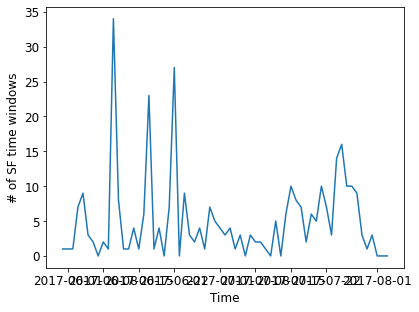

In [20]:
plt.plot(df_group)
plt.xlabel('Time')
plt.ylabel('# of SF time windows')

In [56]:
# Get precipitation data (CransMontana) (ns short for the german Niederschlag (precipitation))
def read_MeteoSwiss(path, files='all', header=14):
    if files == 'all':
        lsmet = os.listdir(path)
    else:
        lsmet = files
        
    met = pd.DataFrame()
    for f in lsmet:
        filepath = os.path.join(path, f)
        d = pd.read_csv(filepath, header = header, delim_whitespace = True)
        d = d.assign(Date = pd.NaT)
        d.Date = pd.to_datetime(dict(year=d.JAHR, month=d.MO, day=d.TG, hour=d.HH, minute=d.MM)) # convert columns (dtype=object) to dates
        d = d.drop(['JAHR','MO','TG','HH','MM','STA'], axis=1) # drop cols, bcs they are in date now
        met = met.append(d)
    
    met = met.set_index('Date')
    
    return met

ns_dat = read_MeteoSwiss(path_to_raw_data[:-9]+'/meteodata/', files=[f'{year}.dat'])
ns_dat['datetime'] = ns_dat.index
ns_dat.head()

/tmp/ipykernel_3535432/65513044.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  met = met.append(d)


,266,261,267,274,269,283,306,580,datetime
Date,,,,,,,,,
2022-01-01 00:00:00,46.1,3.7,0.0,0,2,1.8,867.9,43,2022-01-01 00:00:00
2022-01-01 01:00:00,49.1,3.1,0.0,0,2,1.6,868.0,32767,2022-01-01 01:00:00
2022-01-01 02:00:00,52.9,2.1,0.0,0,2,2.0,867.9,32767,2022-01-01 02:00:00
2022-01-01 03:00:00,51.6,2.6,0.0,0,2,2.1,867.9,32767,2022-01-01 03:00:00
2022-01-01 04:00:00,47.4,3.8,0.0,0,1,2.9,868.0,32767,2022-01-01 04:00:00


In [57]:
# Group by date and sum
ns_group = ns_dat.groupby(ns_dat['datetime'].dt.date).sum()
ns_group.head()

,266,261,267,274,269,283,306,580
datetime,,,,,,,,
2022-01-01,1010.3,151.5,0.0,420,2085,57.4,20820.8,753684
2022-01-02,1033.1,154.7,0.0,134,1364,44.5,20743.8,753683
2022-01-03,1508.8,108.0,0.0,39,1165,38.1,20633.3,753682
2022-01-04,1506.9,167.2,0.5,82,1275,75.8,20350.5,753680
2022-01-05,1770.8,-51.5,2.2,157,1339,80.9,20321.9,753683


In [58]:
ts,te = DF_detections(year) # start and endtimes of DFs

In [59]:
# Start and endtimes of debris-flow events
ts,te = DF_detections(year) # start and endtimes of DFs


# Get times of all slope failure events
tslops = []
dslops = []
for x,y in zip(dttimes, all_class):
    if y != 0:
        tslops.append(x)
        dslops.append(y) # list with 1's for slope failure detections
len(dslops)

2210

In [60]:
# Get start and endtime
tstart = obspy.UTCDateTime(df_group.index[0]) #obspy.UTCDateTime(f'{year}-06-20')
tend = obspy.UTCDateTime(df_group.index[-1]) #tstart + timedelta(days=7*12)

# Mask data untl 3 hours before and 5 hours after
gr_mask = (df_group.index > tstart.date) & (df_group.index <= tend.date) # daily
ns_mask = (ns_dat.index > tstart.datetime) & (ns_dat.index<= tend.datetime) # houerly
ns_gr_mask = (ns_group.index > tstart) & (ns_group.index<= tend) #daily
df_gr_mask = df_group[gr_mask]
df_ns_mask = ns_dat[ns_mask]
df_ns_gr_mask = ns_group[ns_gr_mask]

(153.5, 0.0)

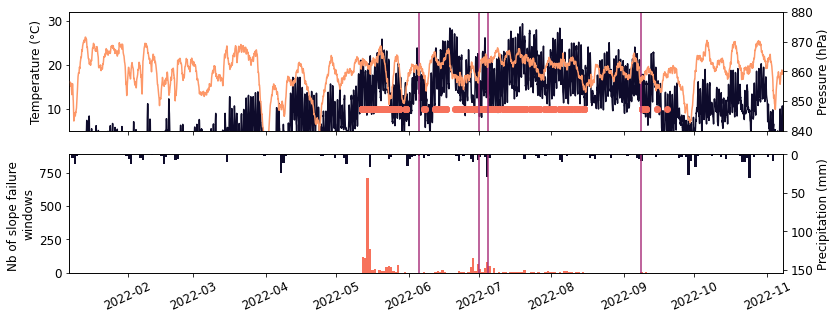

In [63]:
cmcolors = plt.get_cmap('magma').colors
# Specify colors
colors = [cmcolors[20],cmcolors[120],cmcolors[180],cmcolors[200]]
    
fig, (ax1,ax0) = plt.subplots(2,1,figsize=(6.4*2, 4.8), sharex=True)
# Plot air temperature over time
ax1.plot_date(df_ns_mask.index, df_ns_mask['261'], '-', color=colors[0], label='Air temperature')
# Plot slope failures over time
ax1.plot(dttimes, [x*10 for x in all_class], 'o', color=colors[2], label='Slope failures')

ax1.set_ylim(5,32)

ax2 = ax1.twinx()
ax3 = ax0.twinx()
# Plot precipitation over time
ax2.plot_date(df_ns_mask.index, df_ns_mask['306'], '-',color=colors[3], label='Atmospheric pressure')

ax1.set_ylabel('Temperature (°C)')
ax2.set_ylabel('Pressure (hPa)')
ax2.set_ylim(840,880)
#ax1.set_xlim(datetime.strptime('201906191945', "%Y%m%d%H%M"), datetime.strptime('201909191945', "%Y%m%d%H%M"))
ax1.set_xlim(tstart.datetime,tend.datetime)

# Plot debris-flow events as vertical lines
for ts_i in ts:
    ax1.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), color=colors[1])
    ax3.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), color=colors[1])

# Plot slope failures per day
ax0.bar(df_gr_mask.index, df_gr_mask['classes'], width=1, color=colors[2],align='edge', label='Nb of slope failures per day')
ax0.xaxis_date()
ax0.set_ylabel('Nb of slope failure \nwindows')
ax0.tick_params(axis='x', rotation=25)
ymax = np.max(df_gr_mask['classes'])+0.25*np.max(df_gr_mask['classes'])
ax0.set_ylim(0,ymax)

# Plot precipitation per daz
ax3.bar(df_ns_gr_mask.index, df_ns_gr_mask['267'], width=1 ,color=colors[0], align='edge', label='Precipitation per day')
ax3.xaxis_date()
ax3.set_ylabel('Precipitation (mm)')
ax3.set_ylim(0,np.max(df_ns_gr_mask['267'])/(ymax-np.max(df_gr_mask['classes']))*ymax) # adjust the second yscale to 100%
ax3.set_ylim(ax3.get_ylim()[::-1])

#plt.savefig(f'../plot/{year}/0_eval_{year}_{plot_ending}.png',bbox_inches='tight', dpi=300)


In [64]:
# Get start and endtime
#tstart = obspy.UTCDateTime(f'{year}-06-21')
tend = tstart + timedelta(days=7)

# Mask data untl 3 hours before and 5 hours after
gr_mask = (df_group.index > tstart.date) & (df_group.index <= tend.date) # daily
ns_mask = (ns_dat.index > tstart.datetime) & (ns_dat.index<= tend.datetime) # houerly
ns_gr_mask = (ns_group.index > tstart) & (ns_group.index<= tend) #daily
df_gr_mask = df_group[gr_mask]
df_ns_mask = ns_dat[ns_mask]
df_ns_gr_mask = ns_group[ns_gr_mask]

/tmp/ipykernel_3535432/2728899487.py:30: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  ax0.set_ylim(0,np.max(df_gr_mask['classes']))


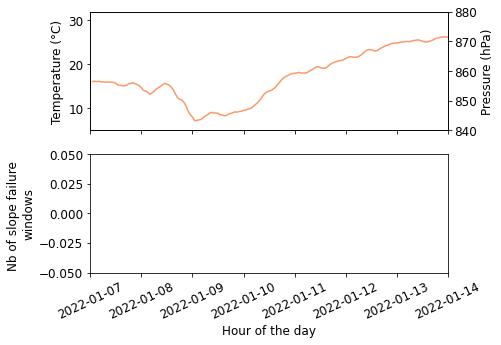

In [65]:
# Zoom in
cmcolors = plt.get_cmap('magma').colors
colors = [cmcolors[20],cmcolors[120],cmcolors[180],cmcolors[200]]
fig, (ax1,ax0) = plt.subplots(2,1,figsize=(6.4, 4.8), sharex=True)

ax1.plot_date(df_ns_mask.index, df_ns_mask['261'], '-', color=colors[0], label='Air temperature at surface')
ax1.plot(dttimes, [x*10 for x in all_class], 'o', color=colors[2], label='Slope failures')

# Plot debris-flow events as vertical lines
for ts_i in ts:
    ax1.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), color=colors[1])
ax1.set_ylim(5,32)

ax2 = ax1.twinx()
ax2.plot_date(df_ns_mask.index, df_ns_mask['306'], '-',color=colors[3], label='Atmospheric pressure')
ax1.set_ylabel('Temperature (°C)')
ax2.set_ylabel('Pressure (hPa)')

# Limit to zoom
#ax1.set_xlim(datetime.strptime('2019060000', "%Y%m%d%H%M"), datetime.strptime('201906230000', "%Y%m%d%H%M"))
ax1.set_xlim(tstart.datetime,tend.datetime)
ax1.tick_params(axis='x', rotation=25)
#ax1.legend(loc='upper right')
#ax2.legend(loc='lower right')
ax2.set_ylim(840,880)

ax0.bar(df_gr_mask.index, df_gr_mask['classes'], width=1, color=colors[2])
ax0.set_xlabel('Hour of the day')
ax0.set_ylabel('Nb of slope failure \nwindows')
ax0.set_ylim(0,np.max(df_gr_mask['classes']))
ax0.tick_params(axis='x', rotation=25)

#plt.legend(bbox_to_anchor = (1.04,1), loc="upper left")

#plt.savefig(f'../plot/{year}/eval_{year}_zoom_{plot_ending}.png', bbox_inches='tight', dpi=300)

## Higher resolution

Plot data in higher resolution during debris-flow events

In [88]:
# Reassemble all window times and classes
class_res = pd.DataFrame({'datetimes': dttimes, 'classes': all_class})
print(class_res.head())

# Group hourly
df_group = class_res.resample('H', on='datetimes').sum()                                                    
print(df_group.head())

# Resample precipitation to hourly sum
ns_group = ns_dat.resample('H', on='datetime').sum()
print(ns_group.head())

            datetimes  classes
0 2021-07-02 00:00:20        0
1 2021-07-02 00:00:30        0
2 2021-07-02 00:00:40        0
3 2021-07-02 00:00:50        0
4 2021-07-02 00:01:00        0
                     classes
datetimes                   
2021-06-23 00:00:00       10
2021-06-23 01:00:00        0
2021-06-23 02:00:00        0
2021-06-23 03:00:00        7
2021-06-23 04:00:00        0
                      266  261  267  274  269  283    306    580
datetime                                                        
2021-01-01 00:00:00  56.3 -3.2  0.0    0    1  2.0  845.3     21
2021-01-01 01:00:00  59.8 -3.7  0.0    0    1  1.4  845.2  32767
2021-01-01 02:00:00  61.0 -4.1  0.0    0    1  1.6  845.2  32767
2021-01-01 03:00:00  57.5 -3.5  0.0    0    1  1.9  845.3  32767
2021-01-01 04:00:00  59.5 -3.4  0.0    0    1  1.4  845.1  32767


In [89]:
# Define which debris-flow event you want to plot
evnb = 2 #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# Get start and endtime
tds = obspy.UTCDateTime(ts[evnb]).datetime
tde = obspy.UTCDateTime(te[evnb]).datetime

# Mask data untl 3 hours before and 5 hours after
dec_mask = (df_group.index > tds - timedelta(seconds=3*3600)) & (df_group.index <= tde + timedelta(seconds=5*3600))
ns_mask = (ns_group.index > tds - timedelta(seconds=3*3600)) & (ns_group.index<= tde + timedelta(seconds=5*3600))
decs = df_group[dec_mask]
nss = ns_group[ns_mask]

tstart = obspy.UTCDateTime(ts[evnb])
tend = obspy.UTCDateTime(te[evnb]) + 5*3600

# Get raw data
st = obspy.read(path_to_raw_data + f"{year}/XP/ILL?8/EHZ.D/*.ILL?8.*{tstart.julday}")
#st1 = st.select(station=["ILL16", "ILL17", "ILL18"])

# Append raw data if endtime is on the next day 
if tend > st[0].stats.endtime:
    st1 = obspy.read(path_to_raw_data + f"{year}/XP/ILL?8/EHZ.D/*.ILL?8.*{tstart.julday + 1}")
    for tr in st1:
        st += tr
    
# Som preprocessing
st.merge(fill_value='interpolate')
st.trim(tstart-3*3600, tend+5*3600)
st.merge(method='interpolate')
st.taper(0.01)
tr = st[0]

# Compute spectrogram
f, t, Sxx = signal.spectrogram(tr.data, tr.stats.sampling_rate, nperseg=1024, noverlap=512, nfft=2048)
tr1 = tr.copy().filter('bandpass', freqmin=5, freqmax=10)
tr1

XP.ILL18..EHZ | 2021-06-22T17:12:46.000000Z - 2021-06-23T07:29:26.000000Z | 100.0 Hz, 5140001 samples

<ipython-input-90-eedf071ee907>:14: RuntimeWarning: divide by zero encountered in log10
  im = ax2.pcolormesh([tr.stats.starttime.datetime + timedelta(seconds=x) for x in t], f, 10*np.log10(Sxx), cmap=cmap, vmin=2,vmax=25,rasterized=True)


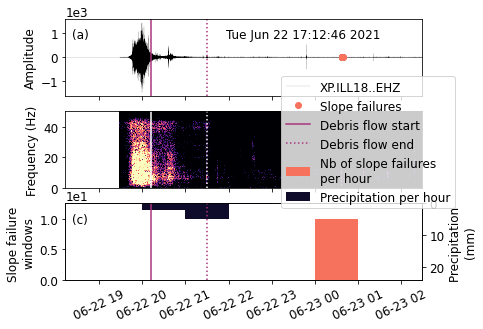

In [90]:
#colors = sns.color_palette('magma', 3)
cmcolors = plt.get_cmap('magma').colors
cmap = plt.get_cmap('magma')
    #colors = cycle([cmcolors[20],cmcolors[100],cmcolors[150],cmcolors[200]])
colors = [cmcolors[20],cmcolors[120],cmcolors[180],cmcolors[200]]
    
fig, (ax1,ax2,ax0) = plt.subplots(3,1,figsize=(6.4, 4.8), sharex=True)
#ax1.plot_date(ns_dat.index, ns_dat['261'], '-', color=colors[0], label='Air temperature')

# Plot raw data
ax1.plot_date(tr1.times('matplotlib'), tr1.data,'k-', linewidth=0.1, label=tr.id)

# Plot spectrogram
im = ax2.pcolormesh([tr.stats.starttime.datetime + timedelta(seconds=x) for x in t], f, 10*np.log10(Sxx), cmap=cmap, vmin=2,vmax=25,rasterized=True)

# Plot slope failures
ax1.plot(tslops, dslops, 'o', color=colors[2], label='Slope failures')

ax2.set_ylabel('Frequency (Hz)')
ax1.set_ylabel('Amplitude')

# Plot bar plot with slope failures per hour
ax0.bar(decs.index, decs['classes'], width=0.042, color=colors[2],  align='edge', label='Nb of slope failures \nper hour')
ax0.xaxis_date()
ax0.set_ylabel('Slope failure \nwindows')
ax0.tick_params(axis='x', rotation=25)
ymax = np.max(decs['classes'])+0.25*np.max(decs['classes'])
ax0.set_ylim(0,ymax)

# Plot bar plot with precipitation per hour
ax3 = ax0.twinx()
ax3.bar(nss.index, nss['267'], width=0.042 ,color=colors[0], label='Precipitation per hour', align='edge')
ax3.xaxis_date()
ax3.set_ylabel('Precipitation \n(mm)')
ax3.set_ylim(0,np.max(nss['267'])/(ymax-np.max(decs['classes']))*ymax) # adjust the second yscale to 100%
ax3.set_ylim(ax3.get_ylim()[::-1]) # slip y scale

# Plot debris-flow start and end
for ax in (ax3,ax1,ax2):
    if ax == ax1:
        ax.axvline(tds, color=colors[1], label= 'Debris flow start')
        ax.axvline(tde, color=colors[1], linestyle=':',label= 'Debris flow end')
    elif ax == ax2:
        ax.axvline(tds, color='white')
        ax.axvline(tde, color='white', linestyle=':')
    else:
        ax.axvline(tds, color=colors[1])
        ax.axvline(tde, color=colors[1], linestyle=':')

ax0.set_xlim(tds - timedelta(seconds=2*3600), tde + timedelta(seconds=5*3600))

#ax3.legend(loc="upper right")
#ax0.legend(loc='lower right')
fig.legend(bbox_to_anchor = [1, 0.75])
#ax2.legend(loc='lower right')
annot = ['(a)','(b)', '(c)']
axes = (ax1, ax2, ax0)
for ax, an in zip(axes,annot):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    if an == '(b)':
        ax.text(xlim[0] + 0.02*(xlim[1] - xlim[0]), ylim[1] - 0.25*(ylim[1] - ylim[0]), an, color='white')
    elif an == '(a)':
        ax.text(xlim[0] + 0.02*(xlim[1] - xlim[0]), ylim[1] - 0.25*(ylim[1] - ylim[0]), an)
        ax.text(xlim[0] + 0.45*(xlim[1] - xlim[0]), ylim[1] - 0.25*(ylim[1] - ylim[0]), tr.stats.starttime.ctime())
    else:
        ax.text(xlim[0] + 0.02*(xlim[1] - xlim[0]), ylim[1] - 0.25*(ylim[1] - ylim[0]), an)
        
ax1.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax0.ticklabel_format(axis='y', style='sci', scilimits=(0,0))

plt.savefig(f'../plot/{year}/0_eval_{tr.stats.starttime.date}_{plot_ending}.png',bbox_inches='tight', dpi=300)

In [91]:
# Get start and endtime
#tstart = obspy.UTCDateTime(f'{year}-06-21')
tstart = obspy.UTCDateTime(obspy.UTCDateTime(ts[evnb]).date)
tend = tstart + timedelta(days=1)

gr_mask = (df_group.index > tstart.datetime) & (df_group.index <= tend.datetime) # daily
ns_gr_mask = (ns_group.index > tstart.datetime) & (ns_group.index<= tend.datetime) #daily
df_gr_mask = df_group[gr_mask]
df_ns_gr_mask = ns_group[ns_gr_mask]

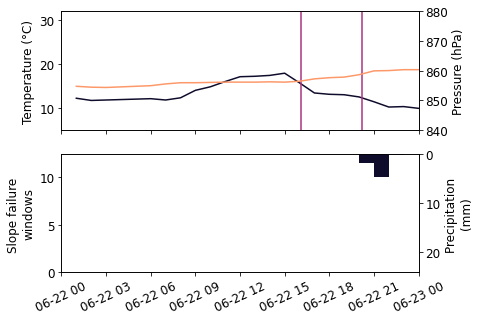

In [92]:
# Zoom in
cmcolors = plt.get_cmap('magma').colors
colors = [cmcolors[20],cmcolors[120],cmcolors[180],cmcolors[200]]
fig, (ax1,ax0) = plt.subplots(2,1,figsize=(6.4, 4.8), sharex=True)

ax1.plot_date(df_ns_gr_mask.index, df_ns_gr_mask['261'], '-', color=colors[0], label='Air temperature at surface')
ax1.plot(dttimes, [x*10 for x in all_class], 'o', color=colors[2], label='Slope failures')

# Plot debris-flow events as vertical lines
for ts_i in ts:
    ax1.axvline(datetime.strptime(ts_i,"%Y-%m-%dT%H:%M:%S"), color=colors[1])
ax1.set_ylim(5,32)

ax2 = ax1.twinx()
ax2.plot_date(df_ns_gr_mask.index, df_ns_gr_mask['306'], '-',color=colors[3], label='Atmospheric pressure')
ax1.set_ylabel('Temperature (°C)')
ax2.set_ylabel('Pressure (hPa)')

# Limit to zoom
#ax1.set_xlim(datetime.strptime('2019060000', "%Y%m%d%H%M"), datetime.strptime('201906230000', "%Y%m%d%H%M"))
ax1.set_xlim(tstart.datetime,tend.datetime)
ax1.tick_params(axis='x', rotation=25)
#ax1.legend(loc='upper right')
#ax2.legend(loc='lower right')
ax2.set_ylim(840,880)

#ax0.bar(df_gr_mask.index, df_gr_mask['classes'], width=0.042, color=colors[2])
#ax0.set_xlabel('Hour of the day')
#ax0.set_ylabel('Nb of slope failure \nwindows')
#ax0.set_ylim(0,np.max(df_gr_mask['classes']))
#ax0.tick_params(axis='x', rotation=25)

# Plot bar plot with slope failures per hour
ax0.bar(df_gr_mask.index, df_gr_mask['classes'], width=0.042, color=colors[2],  align='edge', label='Nb of slope failures \nper hour')
ax0.xaxis_date()
ax0.set_ylabel('Slope failure \nwindows')
ax0.tick_params(axis='x', rotation=25)
ymax = np.max(df_gr_mask['classes'])+0.25*np.max(decs['classes'])
ax0.set_ylim(0,ymax)

# Plot bar plot with precipitation per hour
ax3 = ax0.twinx()
ax3.bar(df_ns_gr_mask.index, df_ns_gr_mask['267'], width=0.042 ,color=colors[0], label='Precipitation per hour', align='edge')
ax3.xaxis_date()
ax3.set_ylabel('Precipitation \n(mm)')
ax3.set_ylim(0,np.max(df_ns_gr_mask['267'])/(ymax-np.max(df_gr_mask['classes']))*ymax) # adjust the second yscale to 100%
ax3.set_ylim(ax3.get_ylim()[::-1]) # slip y scale

#plt.legend(bbox_to_anchor = (1.04,1), loc="upper left")

plt.savefig(f'../plot/{year}/{year}_zoom_h_{plot_ending}.png',bbox_inches='tight', dpi=300)

## Exclude number of events before/during debris flows

In [66]:
# Mask events that happend during debris flows 
class_res = pd.DataFrame({'datetimes': dttimes, 'classes': all_class})
class_mask = class_res.copy()
# dieser Schritt ist möglicherweise nicht nötig -> ich habe noch nichts gelöscht weil den kernel nicht neu gestartet habe
#if year == 2017:
#    ns_mask = xx
#if year == 2018:
#    ns_mask = (ns_dat['datetime'] > datetime.strptime('201807220000', "%Y%m%d%H%M")) & (ns_dat['datetime'] <= datetime.strptime('201810132359', "%Y%m%d%H%M"))
#if year == 2019:
#    ns_mask = (ns_dat['datetime'] > datetime.strptime('201905220000', "%Y%m%d%H%M")) & (ns_dat['datetime'] <= datetime.strptime('201910132359', "%Y%m%d%H%M"))
#if year == 2020:
#    ns_mask = (ns_dat['datetime'] > datetime.strptime('202005280000', "%Y%m%d%H%M")) & (ns_dat['datetime'] <= datetime.strptime('202009302359', "%Y%m%d%H%M"))
#if year == 2021:
#    ns_mask = (ns_dat['datetime'] > datetime.strptime('202105200000', "%Y%m%d%H%M")) & (ns_dat['datetime'] <= datetime.strptime('202107212359', "%Y%m%d%H%M"))
ns_mask = (ns_dat['datetime'] > class_res['datetimes'][0]) & (ns_dat['datetime'] <= class_res['datetimes'][len(class_res)-1])
ns_dat_per = ns_dat[ns_mask].copy()
ns_dat_mask = ns_dat_per.copy()

for i in range(len(ts)):
    tds = obspy.UTCDateTime(ts[i]).datetime
    tde = obspy.UTCDateTime(te[i]).datetime
    dec_mask = (class_res['datetimes'] > tds - timedelta(seconds=3*3600)) & (class_res['datetimes'] <= tde+ timedelta(seconds=1*3600))
    class_mask.loc[class_mask[dec_mask].index, 'classes'] = 0
    ns_mask = (ns_dat['datetime'] > tds - timedelta(seconds=3*3600)) & (ns_dat['datetime'] <= tde+ timedelta(seconds=1*3600))
    ns_dat_mask.loc[ns_dat_per[ns_mask].index, '267'] = 0

/tmp/ipykernel_3535432/1601709200.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ns_dat_mask.loc[ns_dat_per[ns_mask].index, '267'] = 0


In [67]:
df_group = class_res.groupby([class_res['datetimes'].dt.hour]).sum()
#print(df_group.head())

df_group_mask = class_mask.groupby([class_mask['datetimes'].dt.hour]).sum()
df_group_mask.classes = df_group_mask.classes
#print(df_group_mask)

ns_group = ns_dat.groupby([ns_dat_per['datetime'].dt.hour]).sum()
#print(ns_group.head())

ns_group_mask = ns_dat_mask.groupby([ns_dat_mask['datetime'].dt.hour]).sum()
#print(ns_group_mask)

In [68]:
# Group hourly
group_cm = class_res.copy().resample('H', on='datetimes').sum()[1:]
group_cm.index.rename('Date', inplace=True)
group_cm.head(-10)

,classes
Date,
2022-01-07 13:00:00,0
2022-01-07 14:00:00,0
2022-01-07 15:00:00,0
2022-01-07 16:00:00,0
2022-01-07 17:00:00,0
...,...
2022-11-08 08:00:00,0
2022-11-08 09:00:00,0
2022-11-08 10:00:00,0


In [69]:
# Merge classes and precipitation data
group_all = group_cm.merge(ns_dat_mask, how='inner', on='Date')

# Group every 6 hours for clearer picture
group_all5 = group_all.copy().resample('6H', on='datetime').sum()
print(np.max(group_all5['classes']))
print(group_all5.shape)
group_all5.head()

0
(360, 9)


,classes,266,261,267,274,269,283,306,580
datetime,,,,,,,,,
2022-01-10 00:00:00,0,462.4,-21.0,1.6,0,5,7.2,4237.1,163835
2022-01-10 06:00:00,0,525.0,-33.9,0.0,80,751,9.2,5105.7,196602
2022-01-10 12:00:00,0,533.4,-26.8,0.0,98,990,6.2,5126.6,196602
2022-01-10 18:00:00,0,547.6,-53.2,0.0,0,2,9.8,5149.5,196602
2022-01-11 00:00:00,0,503.2,-62.2,0.0,0,2,10.8,5155.9,163903


In [70]:
# ILL16
group_all5_ILL16 = group_all5.copy()

In [71]:
# ILL17
group_all5_ILL17 = group_all5.copy()

In [72]:
# ILL18
group_all5_ILL18 = group_all5.copy()

In [73]:
print(group_all5_ILL16.head())
print(group_all5_ILL17.head())
print(group_all5_ILL18.head())
print(group_all5_ILL16.shape)
print(group_all5_ILL17.shape)
print(group_all5_ILL18.shape)

                     classes    266   261  267  274  269   283     306     580
datetime                                                                      
2022-01-10 00:00:00        0  462.4 -21.0  1.6    0    5   7.2  4237.1  163835
2022-01-10 06:00:00        0  525.0 -33.9  0.0   80  751   9.2  5105.7  196602
2022-01-10 12:00:00        0  533.4 -26.8  0.0   98  990   6.2  5126.6  196602
2022-01-10 18:00:00        0  547.6 -53.2  0.0    0    2   9.8  5149.5  196602
2022-01-11 00:00:00        0  503.2 -62.2  0.0    0    2  10.8  5155.9  163903
                     classes    266   261  267  274  269   283     306     580
datetime                                                                      
2022-01-10 00:00:00        0  462.4 -21.0  1.6    0    5   7.2  4237.1  163835
2022-01-10 06:00:00        0  525.0 -33.9  0.0   80  751   9.2  5105.7  196602
2022-01-10 12:00:00        0  533.4 -26.8  0.0   98  990   6.2  5126.6  196602
2022-01-10 18:00:00        0  547.6 -53.2  0.0    0 

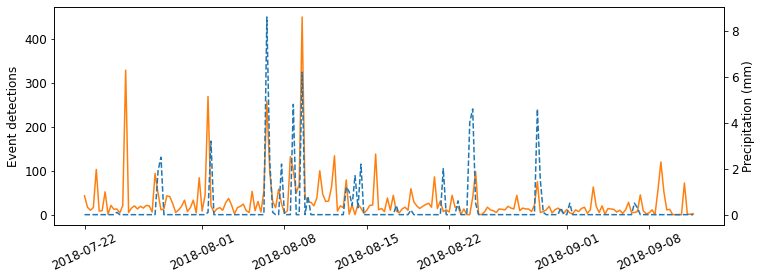

In [282]:
fig = plt.figure(figsize=(12,4))
ax = plt.subplot(111)
ax.plot_date(group_all5.index, group_all5['classes'], 'C1')
ax.set_ylabel('Event detections')
ax1 = ax.twinx()
ax1.plot_date(group_all5.index, group_all5['267'], 'C0',linestyle='--')
ax1.set_ylabel('Precipitation (mm)')
ax.tick_params(axis='x', rotation=25)

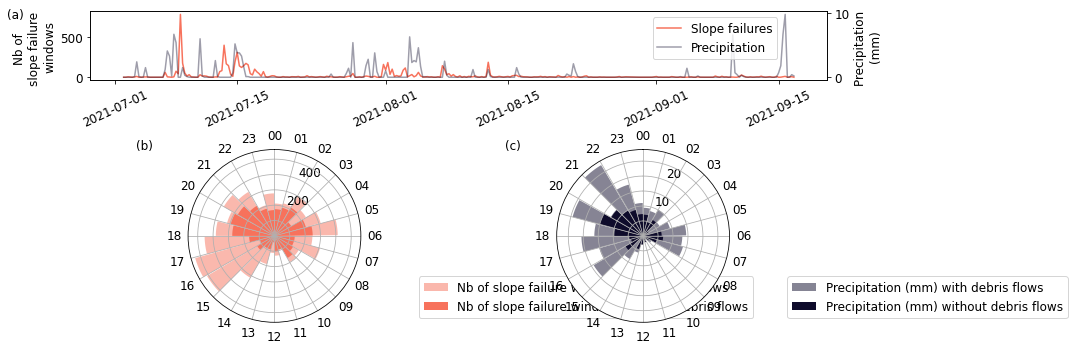

In [97]:
cmcolors = plt.get_cmap('magma').colors
    #colors = cycle([cmcolors[20],cmcolors[100],cmcolors[150],cmcolors[200]])
colors = [cmcolors[20],cmcolors[120],cmcolors[180],cmcolors[200]]
#fig, (ax1,ax0) = plt.subplots(1,2,figsize=(16,3))

fig = plt.figure(figsize = (6.4*2, 4.8))
# [left bottom width height] 
ax2 = fig.add_axes([0.1, 0.75, 0.8, 0.2]) # WAVEFORM
ax0 = fig.add_axes([0.1, 0.05, 0.4, 0.5], projection='polar') # SPECTRUM
ax1 = fig.add_axes([0.5, 0.05, 0.4, 0.5], projection='polar') # COLORBAR

#fig = plt.figure(figsize=(16,6))
#ax2 = plt.subplot(131)
#ax1 = plt.subplot(132, projection='polar')
#ax0 = plt.subplot(133, projection='polar')

ax2.plot_date(group_all5.index, group_all5['classes'], marker=None, linestyle='-', color=colors[2], label='Slope failures')
ax3 = ax2.twinx()
ax3.plot_date(group_all5.index, group_all5['267'], marker=None, linestyle='-', color=colors[0], alpha=0.4, label='Precipitation')
ax2.tick_params(axis='x', rotation=25)
ax2.set_ylabel('Nb of \nslope failure \nwindows')
ax3.set_ylabel('Precipitation \n(mm)')
fig.legend(bbox_to_anchor = [0.85, 0.98])

#ax0.projection('polar')
theta = np.linspace(0.0, 2 * np.pi, len(df_group.index), endpoint=False)
ax0.bar(theta, df_group['classes'], width=0.25, align='edge', color=colors[2], alpha=.5, label='Nb of slope failure windows with debris flows')
ax0.bar(theta, df_group_mask['classes'], width=0.25, align='edge', color=colors[2], label='Nb of slope failure windows without debris flows')
ax1.bar(theta, ns_group['267'], width=0.25, align='edge', color=colors[0], alpha=.5, label='Precipitation (mm) with debris flows')
ax1.bar(theta, ns_group_mask['267'], width=0.25, align='edge', color=colors[0], label='Precipitation (mm) without debris flows')
#ax0.set_xlabel('Hour of the day')
#ax0.set_ylabel('Nb of slope failure \nwindows')
#ax0.set_xlim(-0.5,23.5)
for ax in (ax0,ax1):
    # Make the labels go clockwise
    ax.set_theta_direction(-1)
    #Place Zero at Top
    ax.set_theta_offset(np.pi/2)
    #Set the circumference ticks
    ax.set_xticks(np.linspace(0, 2*np.pi, 24, endpoint=False))
    # set the label names
    ticks = ['00', '01', '02', '03', '04', '05', '06', '07','08','09','10','11','12', '13', '14', '15', '16',  '17', '18', '19', '20', '21', '22', '23' ]
    ax.set_xticklabels(ticks)
    # suppress the radial labels
    #plt.setp(ax0.get_yticklabels(), visible=False)
    for label in ax.yaxis.get_ticklabels()[::2]:
        label.set_visible(False)
    ax.legend(bbox_to_anchor = [1.3, 0.3])
    plt.setp(ax.get_yticklabels()[-1], visible=False)
#plt.setp(ax0.get_yticklabels()[-2], visible=False)
fig.text(0.01,0.93, '(a)')    
fig.text(0.15,0.55, '(b)')
fig.text(0.55,0.55, '(c)')

#plt.savefig(f'../plot/{year}/ns_vs_sf_{plot_ending}.png',bbox_inches='tight', dpi=300)

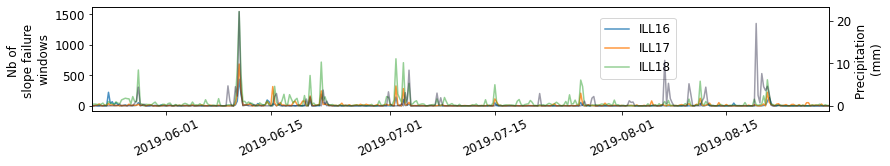

In [153]:
# ONLY TOP PLOT
cmcolors = plt.get_cmap('magma').colors
    #colors = cycle([cmcolors[20],cmcolors[100],cmcolors[150],cmcolors[200]])
colors = [cmcolors[20],cmcolors[120],cmcolors[180],cmcolors[200]]
#fig, (ax1,ax0) = plt.subplots(1,2,figsize=(16,3))

fig = plt.figure(figsize = (6.4*2, 4.8))
# [left bottom width height] 
ax2 = fig.add_axes([0.1, 0.75, 0.8, 0.3]) # WAVEFORM
#ax1 = fig.add_axes([0.5, 0.05, 0.4, 0.5], projection='polar') # COLORBAR

ax2.plot_date(group_all5_ILL16.index, group_all5_ILL16['classes'], marker=None, linestyle='-', alpha=0.8, color='C0', label='ILL16')
ax2.plot_date(group_all5_ILL17.index, group_all5_ILL17['classes'], marker=None, linestyle='-', alpha=0.8, color='C1', label='ILL17')
ax2.plot_date(group_all5_ILL18.index, group_all5_ILL18['classes'], marker=None, linestyle='-', alpha=0.5, color='C2', label='ILL18')

ax3 = ax2.twinx()
ax3.plot_date(group_all5_ILL16.index, group_all5_ILL16['267'], marker=None, linestyle='-', color=colors[0], alpha=0.4, label='Precipitation')
ax2.tick_params(axis='x', rotation=25)
ax2.set_ylabel('Nb of \nslope failure \nwindows')
ax3.set_ylabel('Precipitation \n(mm)')
ax2.legend(bbox_to_anchor = [0.8, 0.95])
ax2.set_xlim(group_all5_ILL18.index[0],group_all5_ILL18.index[-1])

plt.savefig(f'../plot/ns_vs_sf_v4_ILL_b.png',bbox_inches='tight', dpi=300)